In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

### Import training and test data

In [2]:
train = pd.read_csv('/Users/yy/Documents/DNSC_ML/regression/train.csv')
test = pd.read_csv('/Users/yy/Documents/DNSC_ML/regression/test.csv')

In [3]:
train.head() 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

### Exploring the dataset

In [6]:
import matplotlib.pyplot as plt
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

We can use series.describe() to get more information on the variables we are interested in, for example here, we can take a look at our target variable: SalePrice. 

In [7]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Next, we will check for skewness of the data because in linear regression sometimes it's necessary to use log-transformation on the target variable when it's skewed as in this way we can improve the linearity of our data.

Skew is: 1.88287575977


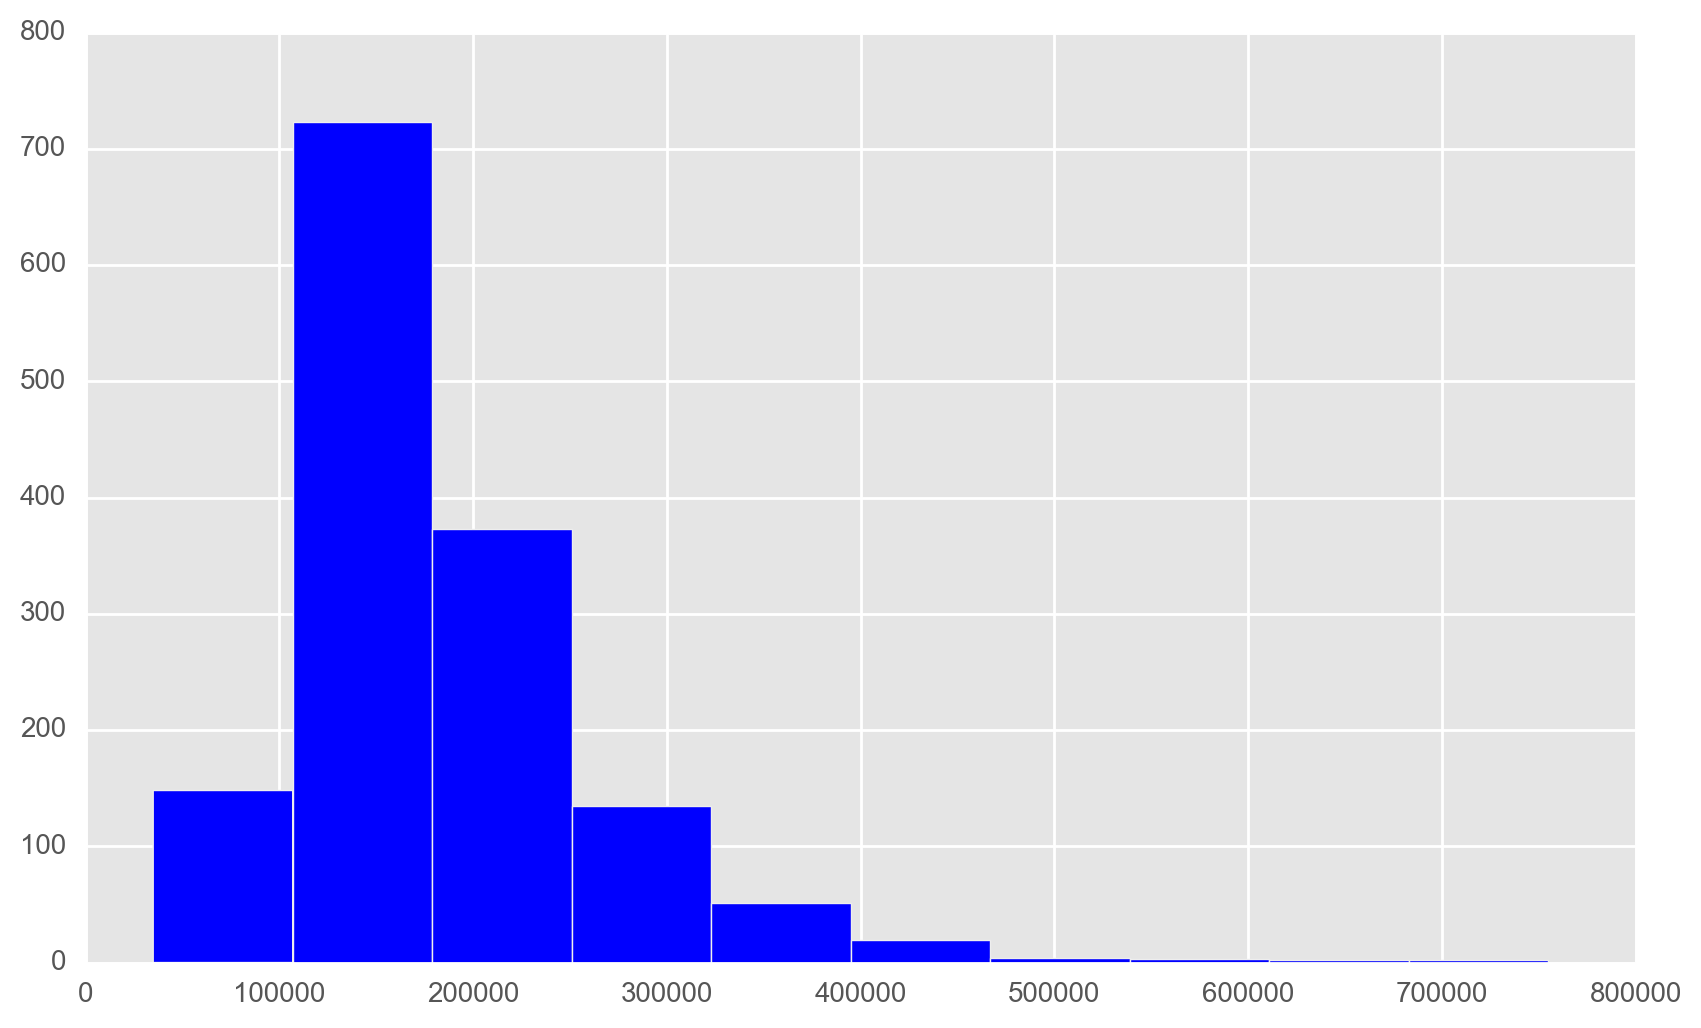

In [8]:
print ("Skew is:", train.SalePrice.skew())
plt.hist(train.SalePrice, color='blue')
plt.show()

### Data Transformation

First we'll transform the skewed data by taking log(feature + 1) - this will normalize the data.

Then, we'll create Dummy variables for the categorical features.

And, we'll replace the numeric missing values (NaN's) with the median of their respective columns, because median always performs better than mean.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11004f860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1143eaba8>]], dtype=object)

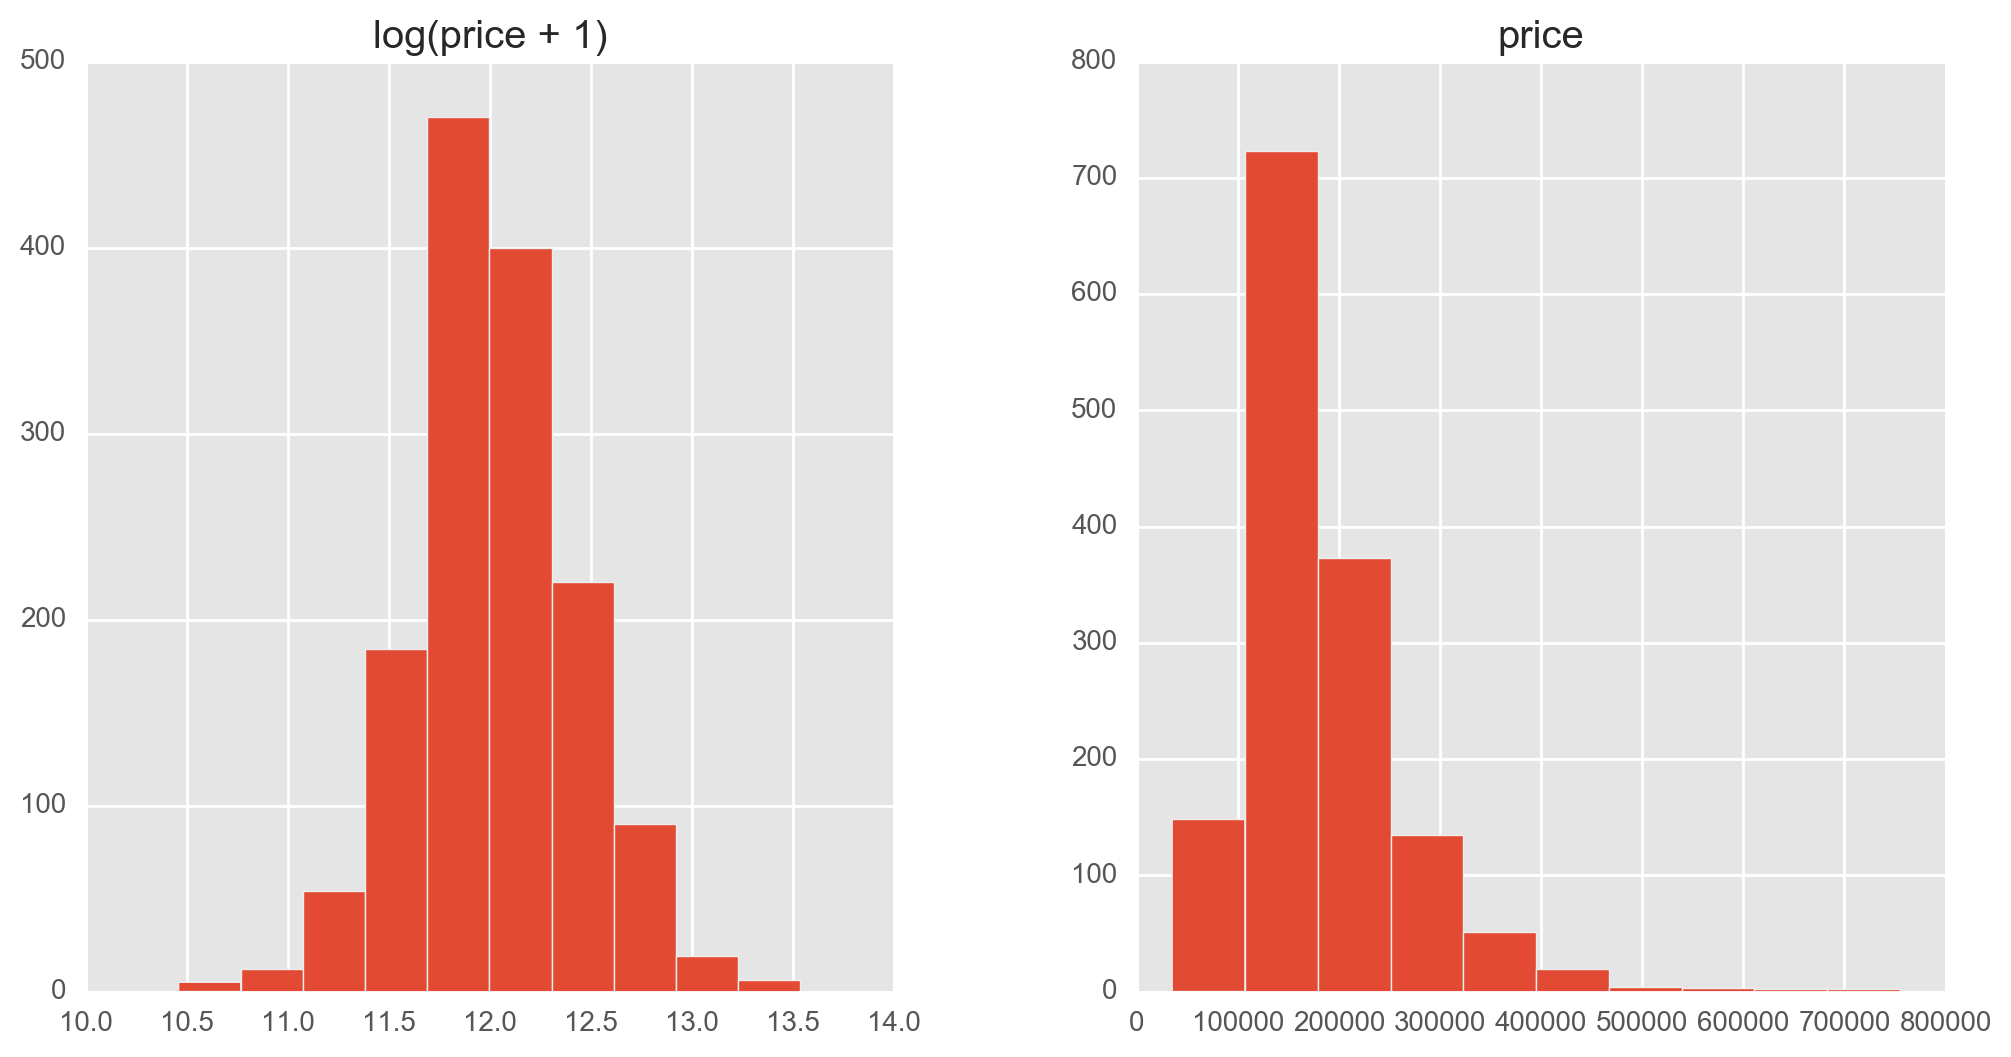

In [9]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])}) 
#numpy.log1p(x[, out]) = <ufunc 'log1p'> Return the natural logarithm of one plus the input array, element-wise.
prices.hist()

In [10]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [11]:
all_data = pd.get_dummies(all_data)

In [12]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.median())

In [13]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

### Model Building

Now we are going to use regularized linear regression models from the scikit learn module. We're going to try both l_1(Lasso) and l_2(Ridge) regularization. We're also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best among those. 

In [14]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [15]:
model_ridge = Ridge()

The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

In [16]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

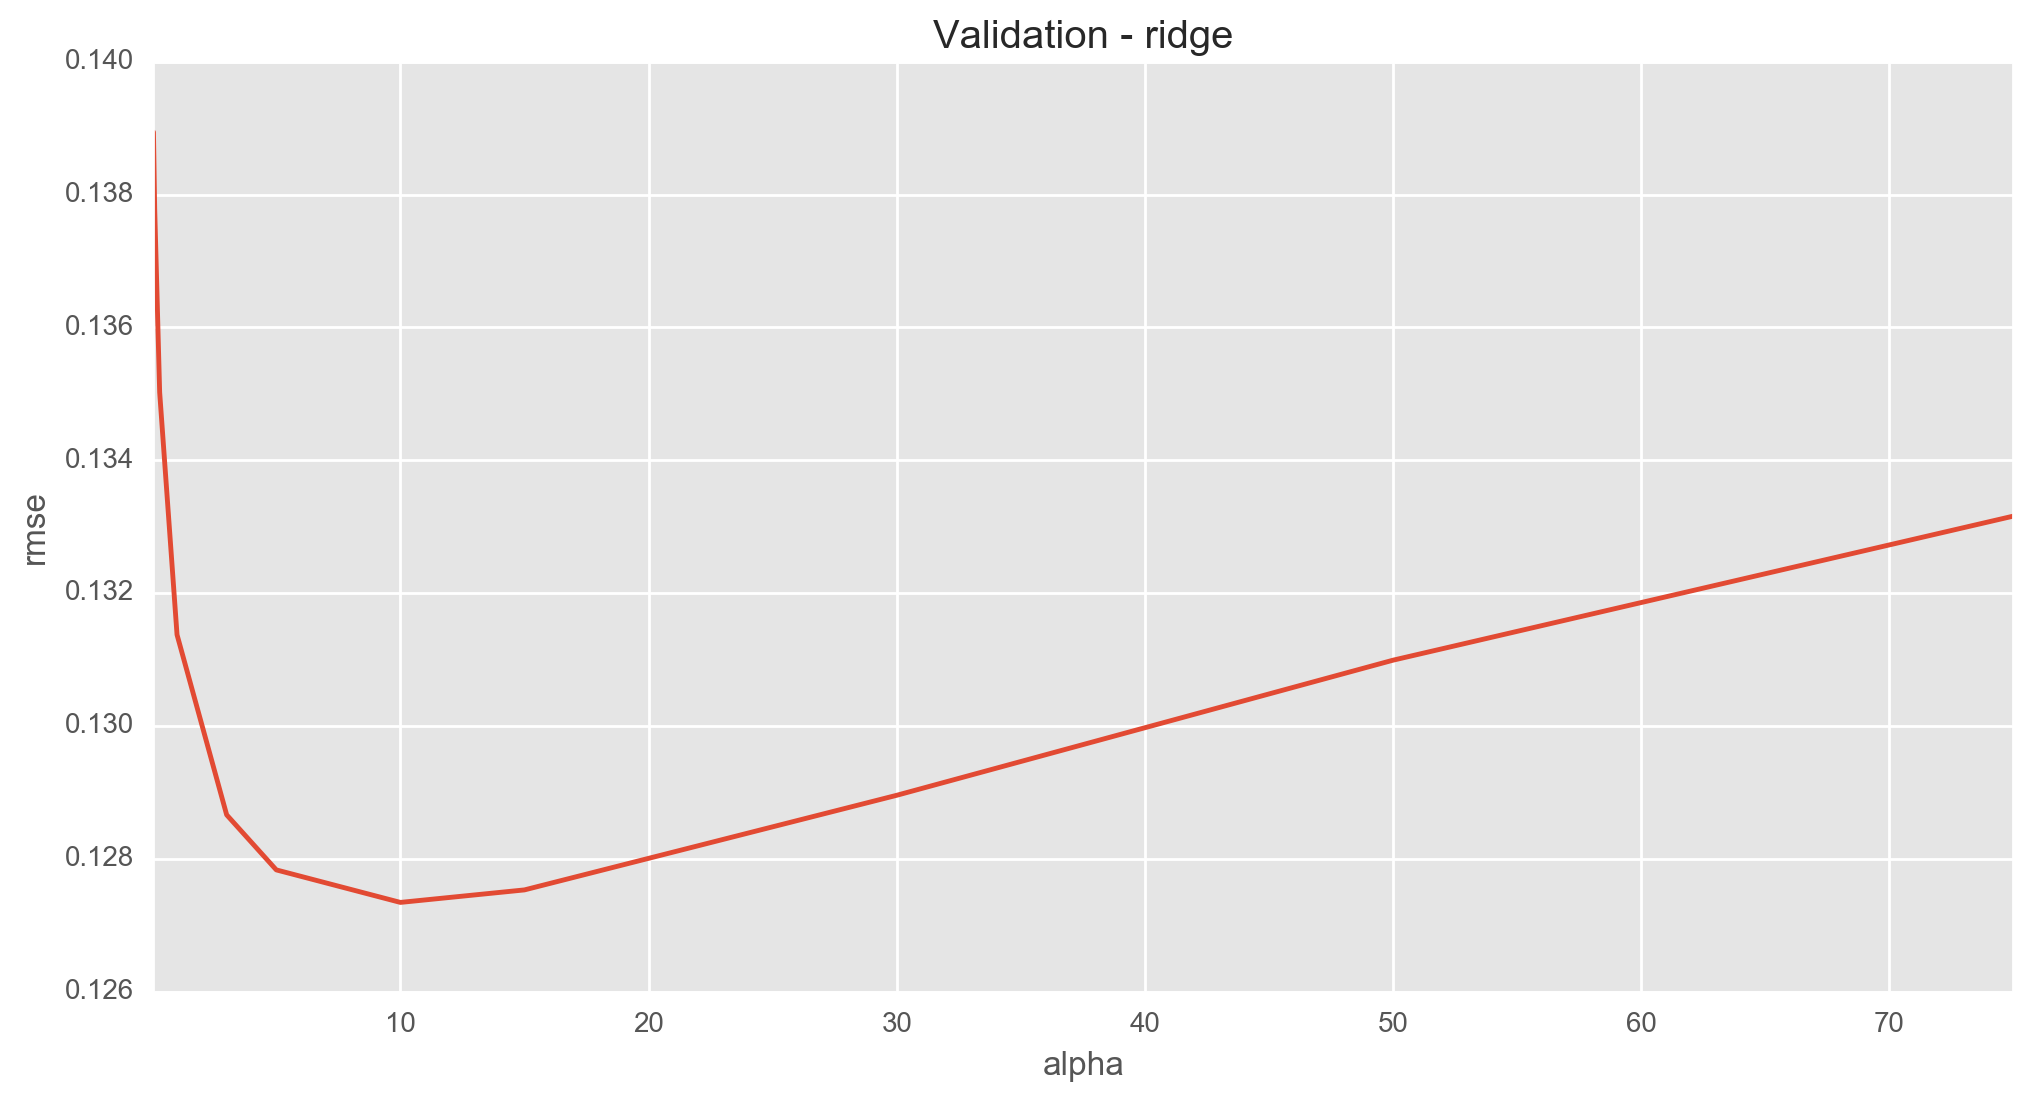

In [17]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - ridge")
plt.xlabel("alpha")
plt.ylabel("rmse")

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above and it's about where the minimum rmse is.

In [18]:
cv_ridge.min()

0.12734362749827211

So for the Ridge regression we get a rmse of about 0.127


Let' try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.

In [19]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [20]:
rmse_cv(model_lasso).mean()

0.12315130553974925

From the above result, we can see the Lasso model outperforms the Ridge model and we have a rmse as low as 0.123.

Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [21]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

In [22]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 111 variables and eliminated the other 177 variables


One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of collinear features in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficients are:

In [23]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

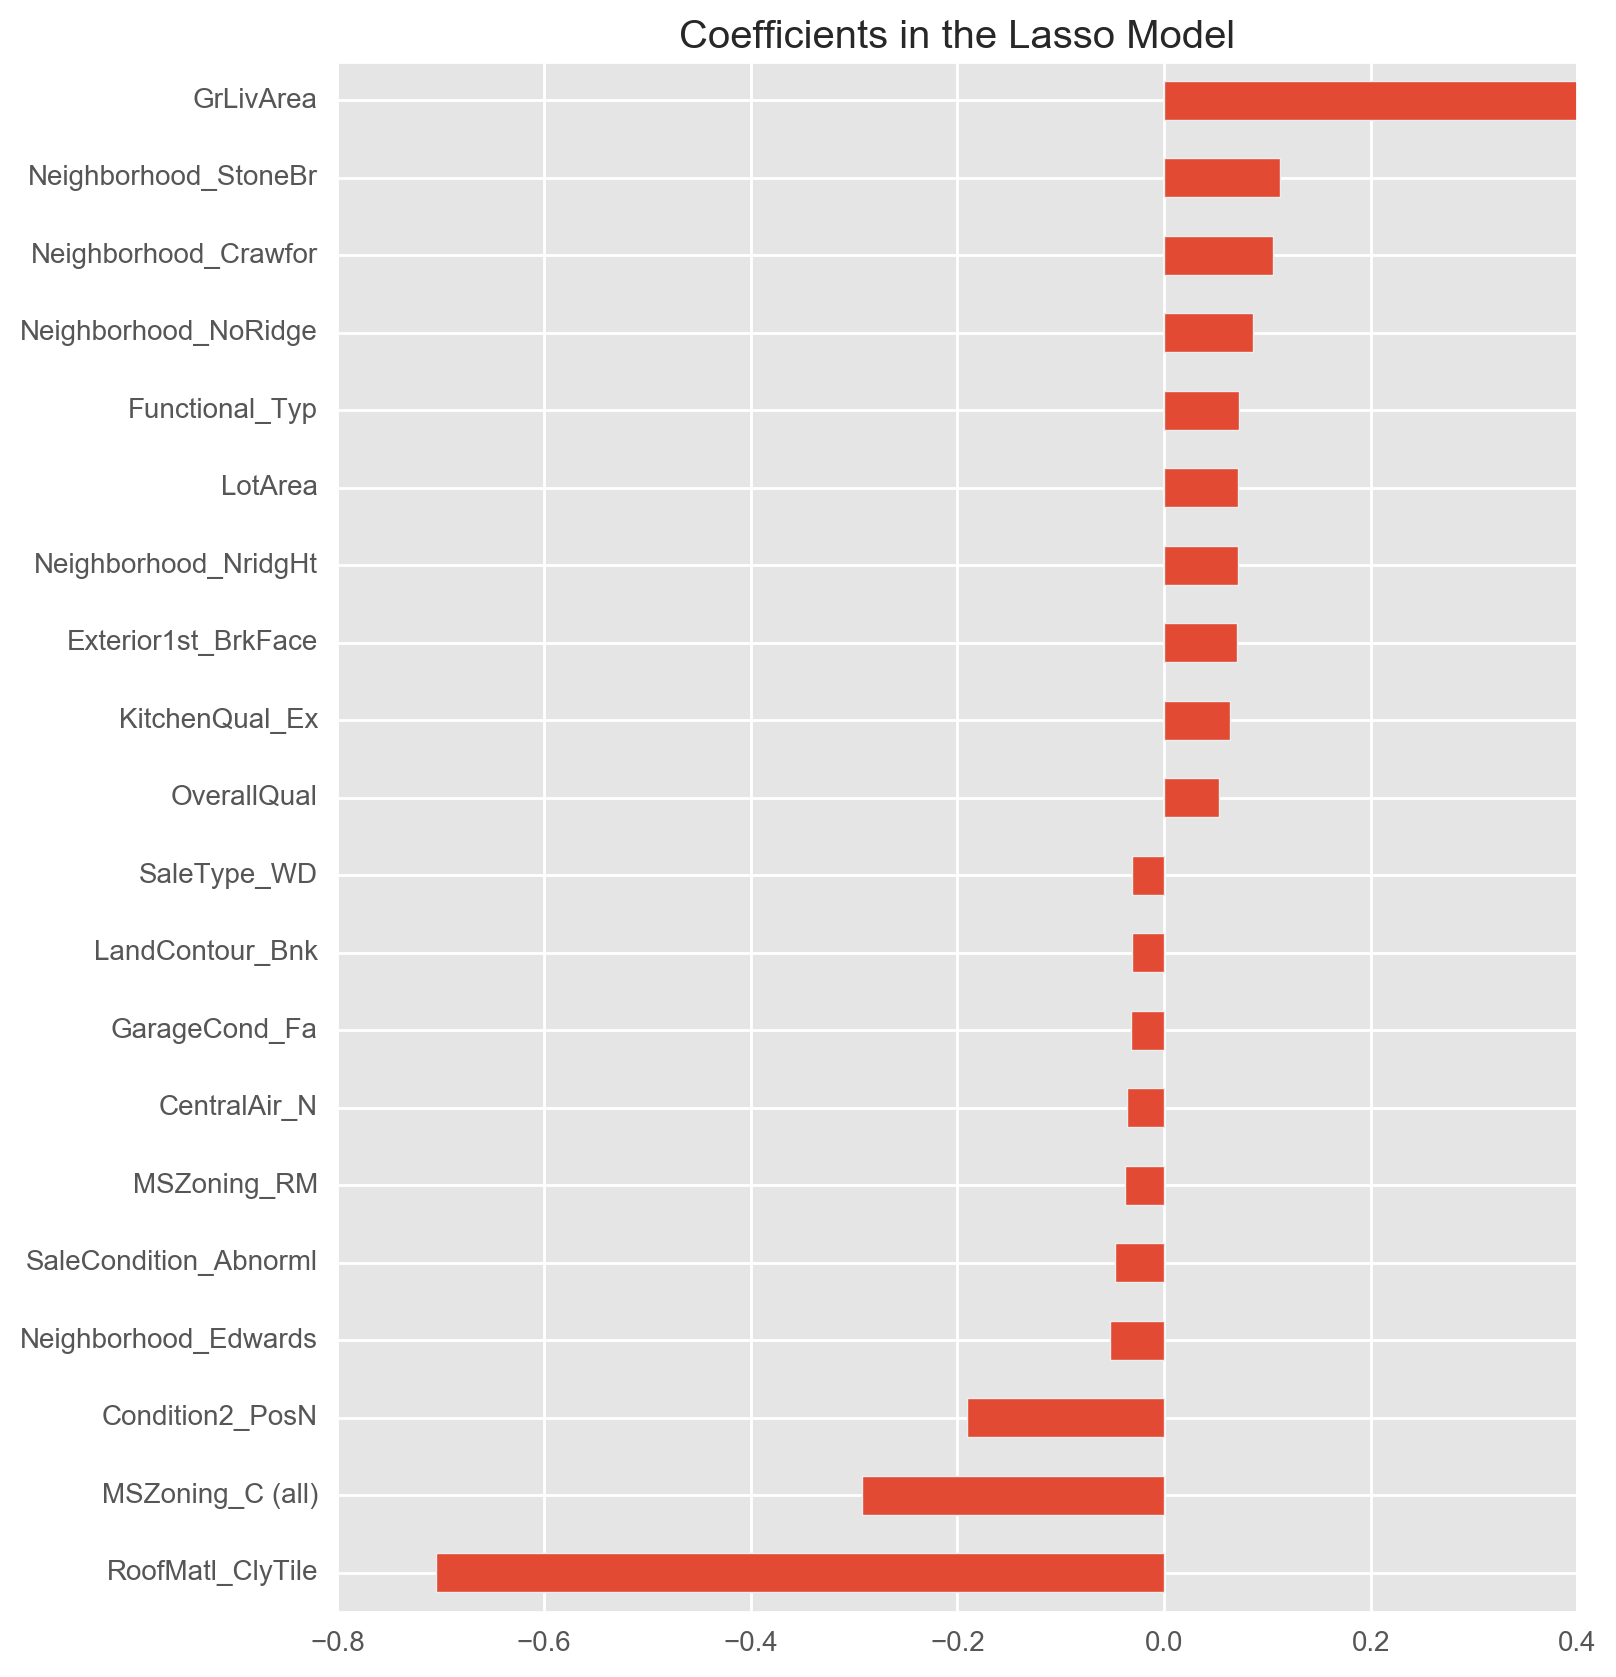

In [24]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

The most important positive feature is GrLivArea - the above ground area by area square feet.There are other neighborhood conditions and location features contributed positively. 

Let's look at the residuals as well:

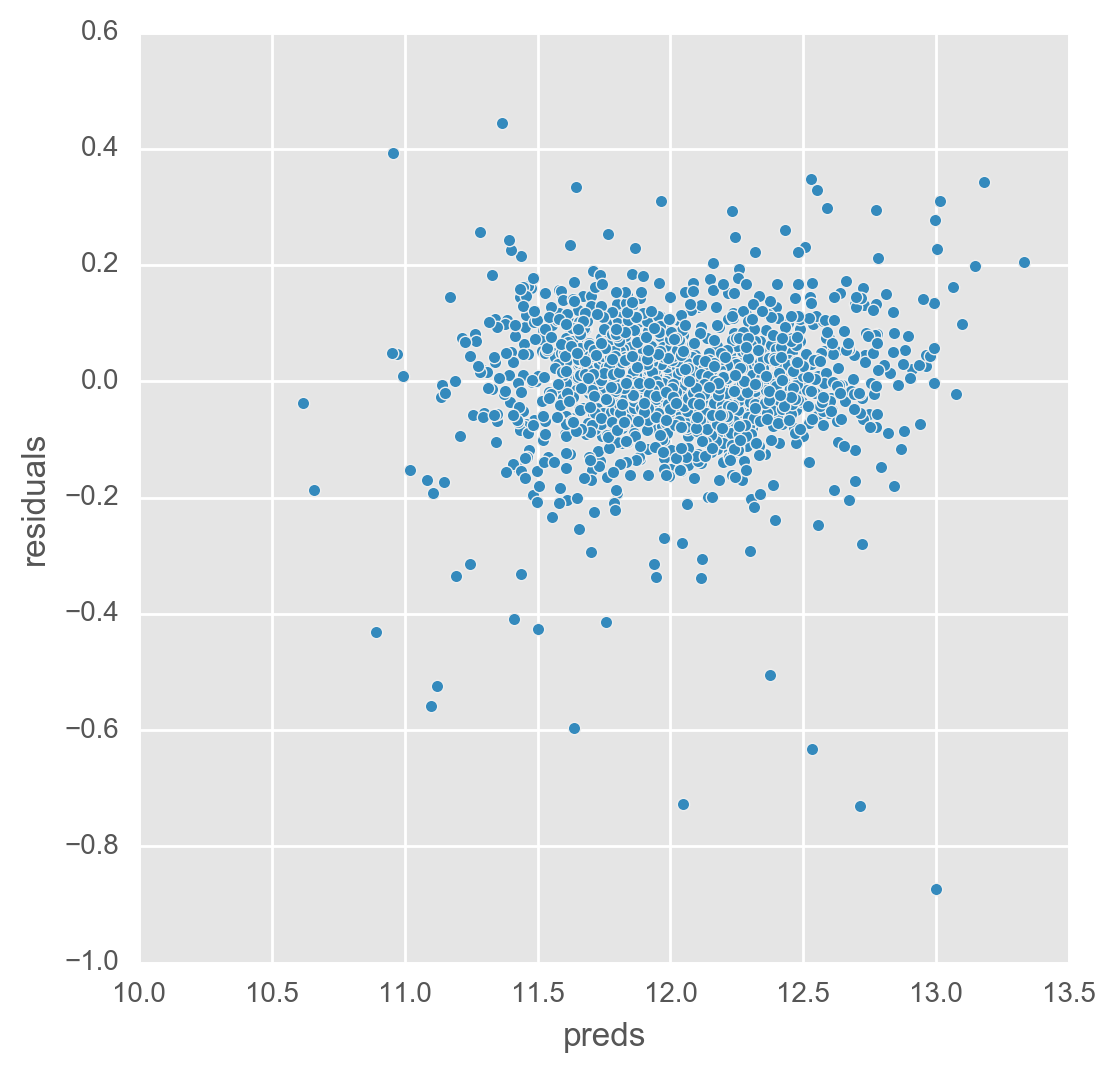

In [26]:

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

The residual plot looks pretty good

### Adding an xgboost model:

Let's add an xgboost model to our linear model to see if we can improve our score:

In [27]:
import xgboost as xgb

/Users/yy/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [28]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

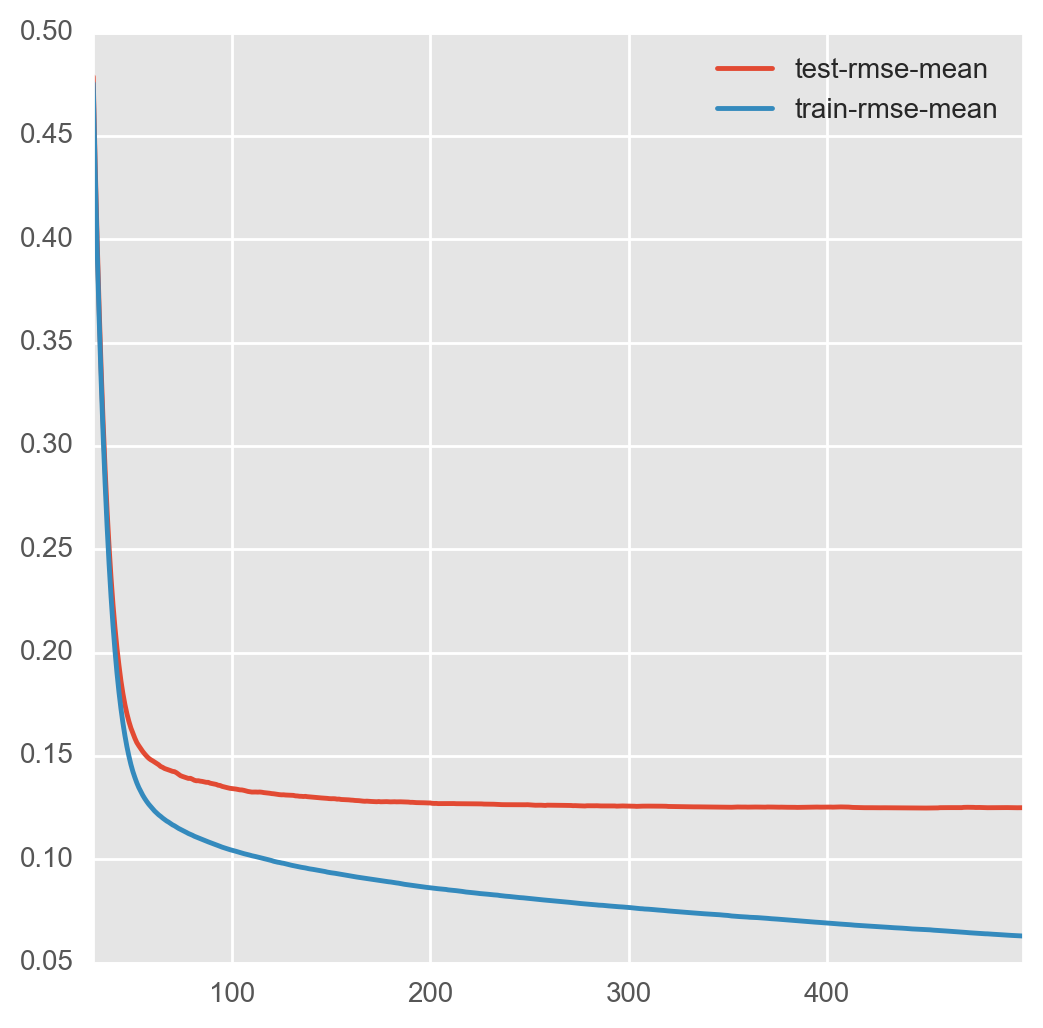

In [29]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [30]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [31]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

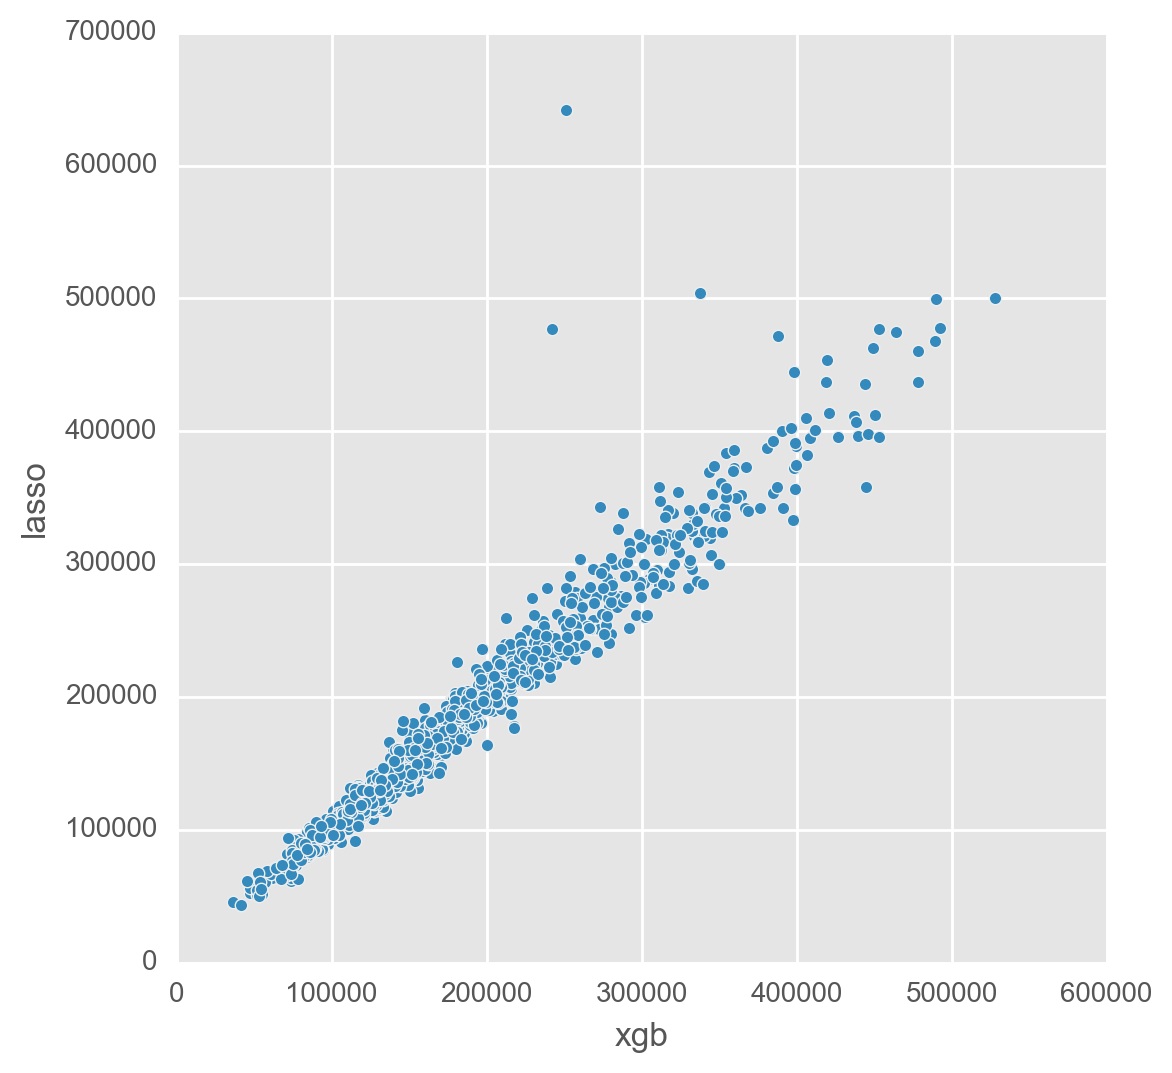

In [32]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = "scatter")